# 4. Eye movement simulation (Stage 2a: Sampling)
This Jupyter notebook gives examples of how to generate synthetic fixational eye movement data using ERICA. Eye movement data can be passed directly to the sampling function (described in notebook "5. Sampling") but it may be prefereable to generate the data in advance and save it for later use (or re-use). The standard format for multidimensional array data used by ERICA is the Flexible Image Transport System (FITS). You can of course save and load the data using another format.

The main inputs in this notebook are: the system_parameters yaml file, which is used to match the pixel rate of your synthetic AOSLO; the total time (seconds) for the eye movement; and the fixation parameters file (by default this is fixation_parameters_default.yaml). This is sufficient to generate an eye movement trace. Below we also show how to separately generate tremor, drift and a microsaccade.

This eye movement model can be updated in the future, or you can use your own eye movement data instead.

<br>
<br>First we start by importing the relevant modules:

In [23]:
%matplotlib inline
import matplotlib

import numpy
import os
import yaml
import sys

from matplotlib import pyplot
from astropy.io import fits

from ERICA import fixation_simulation, ERICA_toolkit, AOSLO_system

current_directory = os.getcwd()

Here we set some default values:

In [24]:
# Flag whether data are to be plotted and/or saved. N.b for faster operation, turn off plotting with PLOT = 0
SAVE = 1
PLOT = 1

# The default colour map for plotting
colour_map = pyplot.get_cmap('viridis')

# Specify a downsampling rate for plotting only (so that the plot loads faster)
down_sample_for_plotting = 8000

# Eye movements are generated with a lower temporal resolution and then upsampled at the end. This speeds up 
# data generation. The subsampling number should be small, and no larger than number of pixels per scan line, to avoid 
# undersampling. The default is 64
subsample_rate = 64

Below are some plotting functions that we will use later to inspect the data that is generated

In [25]:
def plotXandY(t, mx, my, ms_marker=[[numpy.nan, numpy.nan]], downsample_for_plotting=down_sample_for_plotting, cmap=colour_map):
    ''' Plots the horizontal (x) and vertical (y) data as separate lines'''
    fig_1 = pyplot.figure(1, figsize=(12,4))
    fig_1.clf()
    ax1 = fig_1.add_subplot(111)
    ax1.plot(t[::downsample_for_plotting], mx[::downsample_for_plotting], color='b', label='Horizontal motion')
    ax1.plot(t[::downsample_for_plotting], my[::downsample_for_plotting], color='g', label='Vertical motion')

    for i in range(len(ms_marker)):
        for j in range(2):
            if numpy.isnan(ms_marker[i][j]) == False:
                idx = int(ms_marker[i][j]-(-1)**j)
                if i==0 and j==0:
                    
                    ax1.axvline(t[idx], color='purple', label='Microsaccade', linestyle='--', alpha=0.5, linewidth=1)
                else:
                    ax1.axvline(t[idx], color='purple', linestyle='--', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (arcmin)')
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.set_xlim(t.min(), t.max())
    fig_1.subplots_adjust(top=0.96, left=0.07, right=0.84, bottom=0.12)
    return fig_1
        

def plotXY(t, mx, my, downsample_for_plotting=down_sample_for_plotting, cmap=colour_map):
    '''Plots the motion trace in 2D space'''
    fig_2 = pyplot.figure(2, figsize=(6,4))
    fig_2.clf()
    ax2 = fig_2.add_subplot(111)

    line = ERICA_toolkit.colorline(mx[::downsample_for_plotting],my[::downsample_for_plotting], ax2,cmap=cmap, clp=255, linewidth=1)

    cbaxes = fig_2.add_axes([1.0, 0.1, 0.03, 0.8]) 
    norm = matplotlib.colors.Normalize(vmin=numpy.floor(t.min()), vmax=numpy.ceil(t.max()))
    cb1 = matplotlib.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=norm, orientation='vertical')
    cb1.set_label('Time (s)')

    ax2.set_xlabel('Horizontal position (arcmin)')
    ax2.set_ylabel('Vertical position (arcmin)')
    ax2.set_xlim(numpy.floor(mx.min())-5,numpy.ceil(mx.max())+5)
    ax2.set_ylim(numpy.floor(my.min())-5,numpy.ceil(my.max())+5)
    fig_2.subplots_adjust(top=0.96, left=0.12, right=0.94, bottom=0.12)
           
    return fig_2
        

## 4.1 Set up your AOSLO
As described in notebook "1. Setting up your AOSLO", first we need to create an instance of an AOSLO object based on the <span style='background-color:rgb(206,190,218)'>system parameter file</span>. This allows us to access information about the AOSLO, such as the time sampling resolution.


In [26]:
# Specify the AOSLO system parameter file to use
system_parameters_file =  'system_parameters_demo.yaml'
sys.stdout.write('Using parameter file: %s'%system_parameters_file)

# Create the AOSLO instance
myAOSLO = AOSLO_system.AOSLO(os.path.normpath(os.path.join(current_directory, 'System_parameters', system_parameters_file)))
                                              

Using parameter file: system_parameters_demo.yaml

## 4.2. Set up an oculomotor system
Next we create an instance of a Fixation object, based on the <span style='background-color:rgb(236,178,211)'>fixational eye movement parameter file</span>. You can think of this object as being an oculomotor system and the instance we create (myEyeMotion) is an individual oculomotor system that has particular properties. We could create more instances with different properties if we wanted, each behaving differently based on the parameters we have set. 

The properties of the oculomotor system are specified in a fixation parameters file. Parameters that can be specified include the amplitude, centre frequency and bandwidth of tremor, the amplitude of drift, and the amplitude, and time between microsaccades.

In [27]:
# Specify the fixational ye motion parameter file to use
fixation_parameters_file = os.path.normpath(os.path.join(current_directory, 'Fixation_parameters', 'fixation_parameters_default.yaml'))
sys.stdout.write('Using parameter file: %s'%system_parameters_file)

# Create an instance of the Fixation object
myEyeMotion = fixation_simulation.Fixation(fixation_parameters_file, myAOSLO.time_resolution, subsamp=subsample_rate)

Using parameter file: system_parameters_demo.yaml

These parameters are stored in a Python dictionary as an attribute of myEyeMotion. We can take a look at these, as we did for myAOSLO (spatial units are arcminutes, temporal units are seconds and Hz):

In [28]:
for key in myEyeMotion.parameters.keys():
    sys.stdout.write('%s : %f \n'%(key, myEyeMotion.parameters[key]))

Drift_amplitude_arcmin_MEAN : 6.500000 
Drift_amplitude_arcmin_STD : 0.700000 
Main_sequence_STD : 1.000000 
Main_sequence_factor : 100.000000 
Microsaccade_amplitude_arcmin_MEAN : 30.000000 
Microsaccade_amplitude_arcmin_STD : 3.000000 
Microsaccade_interval_seconds_MEAN : 1.000000 
Microsaccade_interval_seconds_STD : 0.500000 
Minimum_microsaccade_interval : 0.100000 
Minimum_time_microsaccade : 0.100000 
Tremor_amplitude_arcmin_MEAN : 0.080000 
Tremor_amplitude_arcmin_STD : 0.030000 
Tremor_bandwidth_MEAN : 25.000000 
Tremor_bandwidth_STD : 2.500000 
Tremor_centre_frequency_MEAN : 65.000000 
Tremor_centre_frequency_STD : 7.500000 


## 4.3 Generate an eye movement trace
First, we set up where the eye movement data will be saved. As the time sampling is matched to the AOSLO, we'll save the data in a folder named after the AOSLO system parameters file, inside the "Eye_motion" folder:

In [29]:
# Set up where data are saved - here we use the default folder "Eye_motion" within the main directory
if os.path.isdir(os.path.normpath(os.path.join(current_directory, 'Eye_motion'))) == 0:
    os.mkdir(os.path.normpath(os.path.join(current_directory, 'Eye_motion')))
    
save_folder_eyemotion = os.path.normpath(os.path.join(current_directory, 'Eye_motion', system_parameters_file.split('.')[0]))
if os.path.isdir(save_folder_eyemotion) == 0:
    os.mkdir(save_folder_eyemotion)    

We first need to specify the length of the eye movement trace (<span style='background-color:rgb(236,236,236)'>total time</span>) in seconds:

In [30]:
total_time = 3.0

Then we generate a single eye movement trace according to the default parameters above.

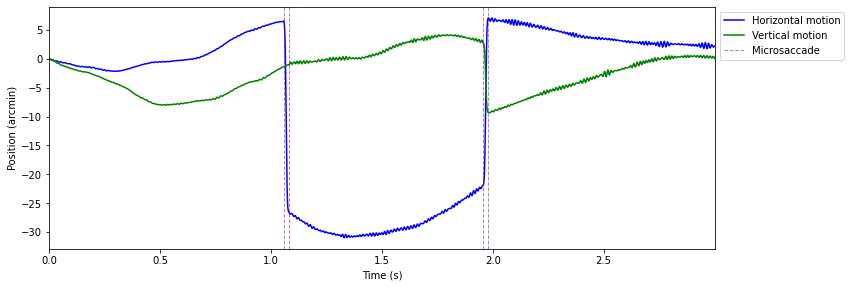

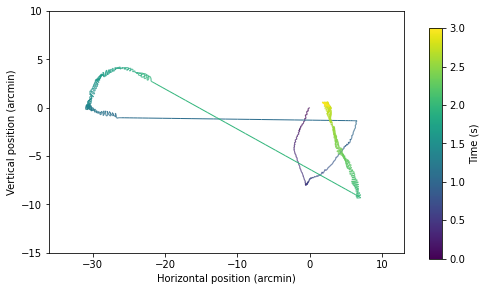

In [32]:
# Create an eye motion trace
motion_x, motion_y, time_samples, fix_param, ms_param, microsaccade_marker = myEyeMotion.fixationalEyemovementTrace(total_time)

# Plot and save the data
if PLOT == 1:

    plot_1 = plotXandY(time_samples, motion_x, motion_y, ms_marker=microsaccade_marker)
    plot_2 = plotXY(time_samples, motion_x, motion_y)


We can save the <span style='background-color:rgb(243,166,173)'>eye position array file</span> to a file (a separate file for vertical and horizontal motion) along with the <span style='background-color:rgb(206,215,247)'>eye movement parameters</span>

In [33]:
if SAVE == 1:

    fits.writeto(os.path.normpath(os.path.join(save_folder_eyemotion, 'trace_y_example.fits')), motion_y, overwrite=True)
    fits.writeto(os.path.normpath(os.path.join(save_folder_eyemotion, 'trace_x_example.fits')), motion_x, overwrite=True)
    fits.writeto(os.path.normpath(os.path.join(save_folder_eyemotion, 'microsaccade_marker_example.fits')), numpy.asarray(microsaccade_marker), overwrite=True)
    fits.writeto(os.path.normpath(os.path.join(save_folder_eyemotion, 'time_samples_example.fits')), time_samples, overwrite=True)
    fits.writeto(os.path.normpath(os.path.join(save_folder_eyemotion, 'microsaccade_parameters_example.fits')), ms_param, overwrite=True)
    fits.writeto(os.path.normpath(os.path.join(save_folder_eyemotion, 'fixation_parameters_example.fits')), fix_param, overwrite=True)

    if PLOT == 1:

        plot_1.savefig(os.path.normpath(os.path.join(save_folder_eyemotion, 'trace_example.png')))

        plot_2.savefig(os.path.normpath(os.path.join(save_folder_eyemotion, 'trace_XY_example.png')))


There is also the option to generate each component of the fixational eye movement separately, as shown in the next few sections.

The following information is also returned with the motion data:

### fix_param
This is an array containing the parameters of the eye motion in each interval between microsaccades, and its shape is (number of inter-microsaccadic periods, 4). Each interval has the following parameters:
1) tremor amplitude (standard deviation, arcminutes)
2) tremor centre frequency (Hz)
3) tremor bandwidth (Full Width Half Maximum, Hz)
4) drift amplitude (maximum deviation, arcminutes)

We can inspect these for the trace shown above:

In [34]:
for i in range(len(fix_param)):
    sys.stdout.write('Fixation period: %i \n'%(i+1))
    sys.stdout.write('Tremor amplitude (standard deviation, arcminutes): %f \n'%fix_param[i][0])
    sys.stdout.write('Tremor centre frequency (Hz): %f \n'%fix_param[i][1])
    sys.stdout.write('Tremor bandwidth (Full Width Half Maximum, Hz): %f \n'%fix_param[i][2])
    sys.stdout.write('Drift amplitude (maximum deviation, arcminutes): %f \n'%fix_param[i][3])
    sys.stdout.write('\n')


Fixation period: 1 
Tremor amplitude (standard deviation, arcminutes): 0.023825 
Tremor centre frequency (Hz): 58.124656 
Tremor bandwidth (Full Width Half Maximum, Hz): 20.138550 
Drift amplitude (maximum deviation, arcminutes): 6.699148 

Fixation period: 2 
Tremor amplitude (standard deviation, arcminutes): 0.080112 
Tremor centre frequency (Hz): 69.439718 
Tremor bandwidth (Full Width Half Maximum, Hz): 23.247209 
Drift amplitude (maximum deviation, arcminutes): 5.902828 

Fixation period: 3 
Tremor amplitude (standard deviation, arcminutes): 0.099415 
Tremor centre frequency (Hz): 69.112362 
Tremor bandwidth (Full Width Half Maximum, Hz): 21.752565 
Drift amplitude (maximum deviation, arcminutes): 6.992342 



### ms_param
This is an array containing the parameters of each microsaccade, and its shape is (number of microsaccades, 3). Each microsaccade has the following parameters: 
1) microsaccade amplitude (maximum deviation, arcminutes)
2) angle (direction from positive horizontal axis, radians),
3) maximum speed (arcminutes/second)

We can inspect these for the trace shown above:

In [35]:
for i in range(len(ms_param)):
    sys.stdout.write('Microsaccade number: %i \n'%(i+1))
    sys.stdout.write('Microsaccade amplitude (maximum deviation, arcminutes): %f \n'%ms_param[i][0])
    sys.stdout.write('Angle (direction from positive horizontal axis, radians): %f \n'%ms_param[i][1])
    sys.stdout.write('Maximum speed (arcminutes/second)]: %f \n'%ms_param[i][2])
    sys.stdout.write('\n')

Microsaccade number: 1 
Microsaccade amplitude (maximum deviation, arcminutes): 33.117994 
Angle (direction from positive horizontal axis, radians): 3.132095 
Maximum speed (arcminutes/second)]: 3433.086157 

Microsaccade number: 2 
Microsaccade amplitude (maximum deviation, arcminutes): 31.501804 
Angle (direction from positive horizontal axis, radians): 5.890107 
Maximum speed (arcminutes/second)]: 3114.380746 



### microsaccade_marker
This is an array containing the indices of the start and end of each microsaccade and its shape is (number of microsaccades, 2). 

We can inspect this for the trace shown above:

In [36]:
for i in range(len(microsaccade_marker)):
    sys.stdout.write('Microsaccade number: %i \n'%(i+1))
    sys.stdout.write('Start index: %i \n'%microsaccade_marker[i][0])
    sys.stdout.write('End index: %i \n'%microsaccade_marker[i][1])
    sys.stdout.write('\n')
    

Microsaccade number: 1 
Start index: 17304576 
End index: 17687232 

Microsaccade number: 2 
Start index: 32039680 
End index: 32440896 



## 4.4 Generate tremor
Tremor is modeled as bandpass filtered Gaussian distributed white noise. The bandpass filter has a Gausian profile and the centre frequency and width (FWHM) can be defined (units = Hz). The amplitude of tremor (units = arcminutes) is defined as the standard deviation of the eye position. As before, we pass the sample time interval and the number of samples to the function.

In [37]:
# Centre temporal frequency of tremor (Hz)
tremor_freq = 65.0
# Width of the tremor temporal frequency band (Hz)
tremor_bd = 7.5
# The amplitude of tremor (arcminutes)
tremor_amp = 0.08

# The total time of the eye movement (seconds)
total_time_tremor = 1.0

# The number of samples in that time period
n_samples_tremor = int(numpy.ceil(total_time_tremor / float(myAOSLO.time_resolution)))

# Set up an array of time samples
time_samp_tremor = numpy.linspace(0, n_samples_tremor - 1, n_samples_tremor) * myAOSLO.time_resolution

# Generate tremor
tremor_motion = fixation_simulation.tremor(tremor_freq, tremor_bd, tremor_amp, myAOSLO.time_resolution, n_samples_tremor)


Then we can plot the data - noting that the array containing the motion has shape (2, n_samples) and is ordered Y, X:

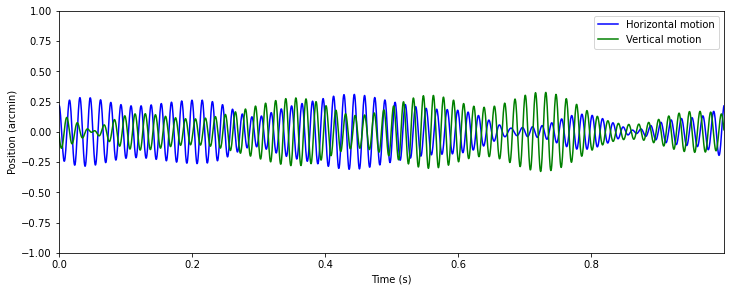

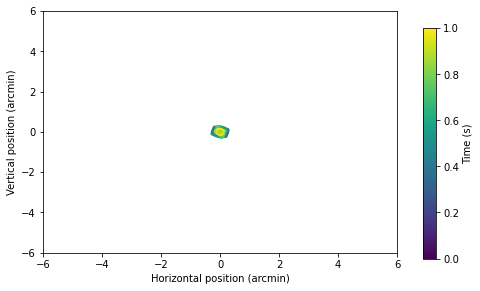

In [38]:
plot_3 = plotXandY(time_samp_tremor, tremor_motion[1],tremor_motion[0])
pyplot.ylim(-1,1)
plot_4 = plotXY(time_samp_tremor, tremor_motion[1], tremor_motion[0])

## 4.5 Generate drift
Drift is modeled as Gaussian distributed white noise filtered by a 1/f$^{2}$ spectrum. The amplitude of drift (units = arcminutes) is defined as the difference between the start and end of the motion. As before, we pass the sample time interval and the number of samples to the function.

In [39]:
# The amplitude of drift (arcminutes)
drift_amp = 6.5

# The total time of the eye movement (seconds)
total_time_drift = 1.0

# The number of samples in that time period
n_samples_drift = int(numpy.ceil(total_time_drift / float(myAOSLO.time_resolution)))

# Set up an array of time samples
time_samp_drift = numpy.linspace(0, n_samples_drift - 1, n_samples_drift) * myAOSLO.time_resolution

# Generate drift
drift_motion = fixation_simulation.drift(drift_amp, myAOSLO.time_resolution, n_samples_drift)

Then we can plot the data:

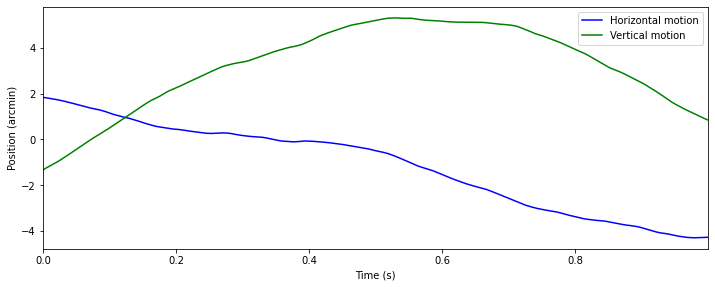

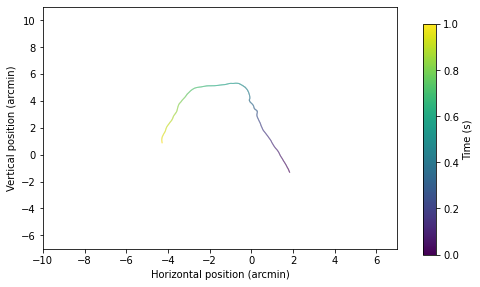

In [40]:
plot_5 = plotXandY(time_samp_drift, drift_motion[1], drift_motion[0])
plot_6 = plotXY(time_samp_drift, drift_motion[1], drift_motion[0])

## 4.6 Generate combined drift and tremor
Periods between microsaccades include both drift and tremor, so typically we want to combined these:

In [41]:
# Centre temporal frequency of tremor (Hz)
tremor_freq = 65.0
# Width of the tremor temporal frequency band (Hz)
tremor_bd = 7.5
# The amplitude of tremor (arcminutes)
tremor_amp = 0.08

# The amplitude of drift (arcminutes)
drift_amp = 6.5


# The total time of the eye movement (seconds)
total_time_tremor_drift = 1.0

# The number of samples in that time period
n_samples_tremor_drift = int(numpy.ceil(total_time_tremor / float(myAOSLO.time_resolution)))

# Set up an array of time samples
time_samp_tremor_drift = numpy.linspace(0, n_samples_tremor-1, n_samples_tremor) * myAOSLO.time_resolution

# Generate tremor
tremor_motion = fixation_simulation.tremor(tremor_freq, tremor_bd, tremor_amp, myAOSLO.time_resolution, n_samples_tremor_drift)

# Generate drift
drift_motion = fixation_simulation.drift(drift_amp, myAOSLO.time_resolution, n_samples_drift)

# Sum tremor and drift
tremor_drift_motion = tremor_motion + drift_motion

Then plot the data:

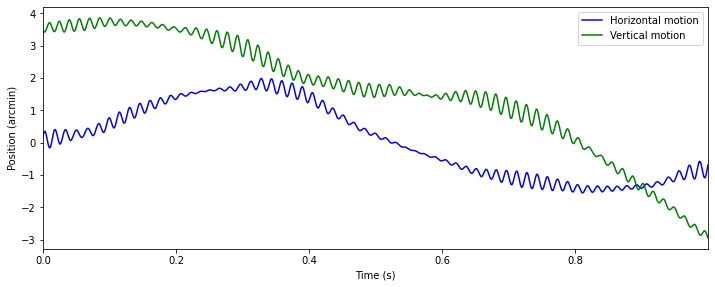

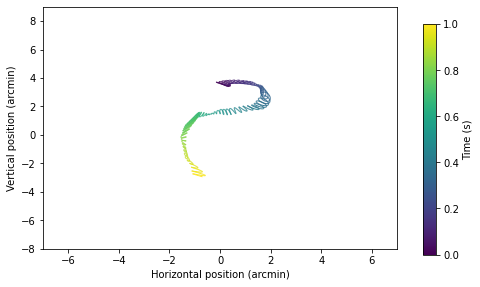

In [42]:
plot_7 = plotXandY(time_samp_tremor_drift, tremor_drift_motion[1], tremor_drift_motion[0])
plot_8 = plotXY(time_samp_tremor_drift, tremor_drift_motion[1], tremor_drift_motion[0])

## 4.7 Generate a microsaccade
Microsaccades are modeled as a ballistic-like movement using a cumulative Gaussian function with specified amplitude and peak speed (determined using the microsaccade main sequence).

In [43]:
# The total time of the eye movement (seconds)
total_time = 0.1

# The number of samples in that time period
n_samples_microsaccade = int(numpy.ceil(total_time / float(myAOSLO.time_resolution)))

# The amplitude of the microsaccade (arcminutes)
microsaccade_amplitude = 15.0

# The direction of the microsaccade (radians), with 0 being along the positive x axis.
microsaccade_angle = numpy.pi/3.

# Log of the amplitude in degrees
l = numpy.log10(microsaccade_amplitude/60.)

# Estimate the maximum speed from the main sequence 
ms = l + numpy.log10(myEyeMotion.parameters['Main_sequence_factor'])
microsaccade_max_speed = 60 * 10**ms       


# Generate the microsaccade
microsaccade = fixation_simulation.microsaccade(microsaccade_amplitude, microsaccade_angle, microsaccade_max_speed, myAOSLO.time_resolution, n_samples=n_samples_microsaccade)

# Set up an array of time samples
time_samp_microsaccade = numpy.linspace(0, microsaccade.shape[1]-1, microsaccade.shape[1]) * myAOSLO.time_resolution

# Calculate the velocity
velocity = (microsaccade[:,1:] - microsaccade[:,:-1]) / myAOSLO.time_resolution

# Estimate the start and end of the microsaccade based on the velocity (i.e. when velocity is larger than 0.1% 
# of the maximum)
radial_velocity = numpy.sqrt(velocity[1]**2 + velocity[0]**2)
microsaccade_start = numpy.where(radial_velocity>radial_velocity.max()*0.001)[0][0]
microsaccade_end = radial_velocity.shape[0] - numpy.where(radial_velocity[::-1]>radial_velocity.max()*0.001)[0][0]

Then we can plot the microsaccade data

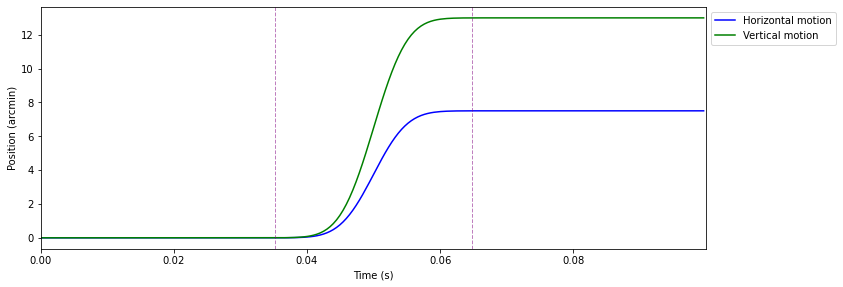

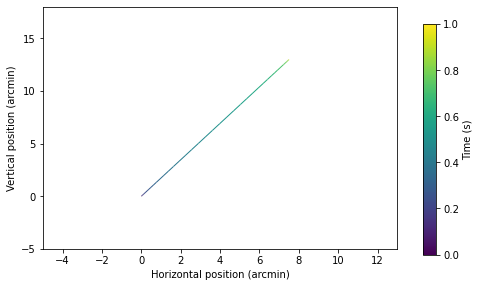

In [44]:
plot_9 = plotXandY(time_samp_microsaccade, microsaccade[1], microsaccade[0])
ax5 = plot_9.get_axes()[0]
ax5.axvline(time_samp_microsaccade[microsaccade_start], color='purple', linestyle='--', alpha=0.5, linewidth=1)
ax5.axvline(time_samp_microsaccade[microsaccade_end], color='purple', linestyle='--', alpha=0.5, linewidth=1)

plot_10 = plotXY(time_samp_microsaccade[microsaccade_start:microsaccade_end], microsaccade[1,microsaccade_start:microsaccade_end], microsaccade[0,microsaccade_start:microsaccade_end])


Finally we can check the velocity profile of the microsaccade:

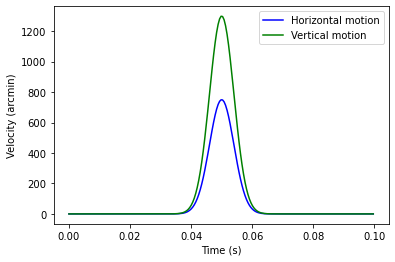

In [45]:
plot_11 = matplotlib.pyplot.figure(7, figsize=(6,4))
ax7 = plot_11.add_subplot(111)
ax7.plot(time_samp_microsaccade[:-1][::down_sample_for_plotting], velocity[1,::down_sample_for_plotting], color='b', label='Horizontal motion')
ax7.plot(time_samp_microsaccade[:-1][::down_sample_for_plotting], velocity[0,::down_sample_for_plotting], color='g', label='Vertical motion')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Velocity (arcmin)')
ax7.legend(bbox_to_anchor=(1,1))